---

# CSCI 3202, Fall 2022
# Homework 8
# Due: Friday November 18, 2022 at 6:00 PM

<br> 

### Your name: Ty VanEssen

<br> 

---

Some useful packages and libraries:



In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import deque
import heapq
import unittest
from scipy import stats
import copy as cp
from time import time

---

## Problem 1: Maximizing an Objective Function with a Genetic Algorithm 

Suppose we've lost the index card with our favorite cupcake recipe. We know the ingredients of the cake, but cannot remember the exact amount of each ingredient. We decide to use a genetic algorithm to generate the  ingredient amounts. With each iteration of the genetic algorithm, we bake the cupcakes and taste-test them. We achieve our goal and stop running the genetic algorithm when we get to the actual recipe: 

* 1 tsp salt 
* 3 tsp baking powder 
* 2 cups all-purpose flour 
* 1 cup butter 
* 1 cup granulated sugar 
* 4 large eggs
* 1 tsp vanilla extract
* 1 cup buttermilk 

In [8]:
target = [1, 3, 2, 1, 1, 4, 1, 1]

An example starting state for a member of our population might look like: $state = [1, 2, 100, 36, 60, 3, 5, 50]$, which is equivalent to 1 tsp salt, 2 tsp baking powder, 100 cups of flour, 36 cups of butter, 60 cups of granulated sugar, 3 large eggs, 5 tsp vanilla, and 50 cups of buttermilk.

### (1a) 

Write an objective function `def recipe_success(state)` that takes a single argument state, and returns the objective function value (fitness) of the state. The objective function should be maximized when a state reaches the target. You could for example define the fitness score of a particular state based on how far away each entry is from the target recipe.

In [68]:
def recipe_success(state):
    # Your code here.
    scale = 1.6
    return 100 * sum(map(lambda s, t: 2 * stats.norm.pdf(s, t, scale) / stats.norm.pdf(t,t, scale), state, target)) / (len(target) * 2)


    # return -1 * sum(map(lambda x,y: (x-y)**2, state, target))

In [69]:
# Write your own test case to make sure that the target element achieves
# the fitness score you would expect it to (this will vary depending on
# what you did here.)
class Tests_Problem1a(unittest.TestCase):
    def test_fitness_good(self):
        self.assertAlmostEqual(recipe_success(target), 100)
    def test_fitness_bad(self):
        self.assertAlmostEqual(recipe_success([0]*8), 39.7429130)
    def test_fitness_worse(self):
        self.assertAlmostEqual(recipe_success(range(9)), 31.1855578)

tests_to_run = unittest.TestSuite()
tests_to_run.addTest(Tests_Problem1a("test_fitness_good"))
tests_to_run.addTest(Tests_Problem1a("test_fitness_bad"))
tests_to_run.addTest(Tests_Problem1a("test_fitness_worse"))
unittest.TextTestRunner().run(tests_to_run)

.FF
FAIL: test_fitness_bad (__main__.Tests_Problem1a)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\Ty\AppData\Local\Temp\ipykernel_16232\1848617216.py", line 8, in test_fitness_bad
    self.assertAlmostEqual(recipe_success([0]*8), 39.7429130)
AssertionError: 59.83849664102622 != 39.742913 within 7 places (20.095583641026217 difference)

FAIL: test_fitness_worse (__main__.Tests_Problem1a)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\Ty\AppData\Local\Temp\ipykernel_16232\1848617216.py", line 10, in test_fitness_worse
    self.assertAlmostEqual(recipe_success(range(9)), 31.1855578)
AssertionError: 46.771287199818815 != 31.1855578 within 7 places (15.585729399818813 difference)

----------------------------------------------------------------------
Ran 3 tests in 0.012s

FAILED (failures=2)


<unittest.runner.TextTestResult run=3 errors=0 failures=2>

### (1b) 

Write a genetic algorithm that starts with a population of 100 randomly generated "recipes/states/members" and uses the objective function you wrote in **(1a)** to hopefully hit the target after a certain number of generations. 

Key components of your code:
- Generate the initial population randomly from integers between 0 and 100 
- Allow for mutations in your population with an overall probability of mutation set to p = 0.2
- Choose 2 "parents" in the generation of each "child"
- Choose a random split point at which to combine the two "parents"
- Run the algorithm for 50 iterations ("generations"). Do you hit your target?

In [73]:
#Your code here 
class genetic_algorithm():
    def __init__(self, objective_function, population_dimensions: tuple[int, int], mutation_probability: float) -> None:
        self.population_dims = population_dimensions
        self.grade = objective_function
        self.mutate_p = mutation_probability
        self.pop = self.init_population()

    def init_population(self) -> np.ndarray[any, int]:
        return np.random.randint(0, 100, size = self.population_dims)

    def mutate(self, member: list[int]) -> list[int]:
        do_mutate: bool = np.random.choice([True, False], p=[self.mutate_p, 1-self.mutate_p])

        if do_mutate:
            # print(np.random.normal(scale=10, size=len(member)))
            # mutated_gene : list[int] = np.random.choice([-2,-1-1,0,0,0,0,0,1,1,2], len(member), True)
            mutated_gene = np.random.randint(-10, 10, len(member))
            for gene_idx in range(len(member)):
                member[gene_idx] += mutated_gene[gene_idx]
                if member[gene_idx] < 0:
                    member[gene_idx] = 100 + member[gene_idx]
                elif member[gene_idx] > 100:
                    member[gene_idx] = member[gene_idx] - 100

        return member

    def reproduce(self, distribution : list[float]) -> list[int]:
        parent1, parent2 = [ self.pop[idx] for idx in np.random.choice(len(self.pop), 2, False, distribution) ]
        split_idx = np.random.randint(low=1, high=self.population_dims[1])
        return list(parent1[:split_idx]) + list(parent2[split_idx:])

    def run_generations(self, n_generations: int, goal_grade: int):
        best_member = None
        for generation_idx in range(n_generations):
            all_performance = [ self.grade(member) for member in self.pop]
            print(generation_idx, np.mean(all_performance), best_member)
            reproduce_p = [ grade/sum(all_performance) for grade in all_performance]

            new_generation = [ self.mutate(self.reproduce(reproduce_p)) for idx in range(len(self.pop))]
            best_member = max([(self.grade(member), member) for member in new_generation])

            if best_member[0] >= goal_grade:
                return best_member
            else:
                self.pop = new_generation
            
        
        return max([(self.grade(member), member) for member in new_generation])

a = genetic_algorithm(recipe_success, (200,8), 0.25)
a.run_generations(500, 100)

0 3.4143640809286877 None
1 10.116857615707756 (32.01027310425697, [99, 5, 4, 83, 0, 3, 62, 98])
2 14.199620411871333 (38.78735608211179, [96, 3, 4, 83, 0, 3, 62, 98])
3 16.381797603289886 (45.57553347196801, [1, 11, 20, 14, 0, 4, 7, 0])
4 19.453333290955523 (46.728053574273666, [1, 5, 4, 87, 0, 4, 76, 68])
5 19.67761804332175 (51.29840391094847, [1, 81, 75, 3, 0, 4, 7, 0])
6 24.576870331952424 (61.58062344093178, [1, 27, 1, 3, 0, 4, 7, 0])
7 27.33239920162732 (61.58062344093178, [1, 81, 1, 3, 0, 4, 7, 0])
8 27.614886703899224 (68.34665858994998, [1, 16, 1, 1, 2, 66, 1, 0])
9 28.88071330389286 (61.56957561209509, [99, 81, 1, 3, 0, 4, 1, 0])
10 31.954723523186168 (63.78735608211179, [2, 5, 2, 43, 1, 4, 44, 0])
11 33.67954875932164 (63.78735608211179, [1, 5, 2, 43, 1, 3, 93, 2])
12 33.484002107985546 (67.29249263424028, [2, 5, 4, 52, 1, 3, 1, 0])
13 33.80396155086058 (76.28735608211178, [2, 3, 4, 1, 0, 4, 1, 97])
14 35.08475880430959 (76.83656775240438, [2, 3, 4, 1, 0, 4, 1, 5])
15 34.00

(100.0, [1, 3, 2, 1, 1, 4, 1, 1])

In [62]:
recipe_success([1, 3, 2, 78, 1, 62, 1, 1])
stats.norm.pdf(100,1)
for i in [[(i, scale, stats.norm.pdf(i, 1, scale)) for i in np.arange(50,100,5)] for scale in np.arange(0.20, 5, .2)]:
    print(i, sep="\t")

[(50, 0.2, 0.0), (55, 0.2, 0.0), (60, 0.2, 0.0), (65, 0.2, 0.0), (70, 0.2, 0.0), (75, 0.2, 0.0), (80, 0.2, 0.0), (85, 0.2, 0.0), (90, 0.2, 0.0), (95, 0.2, 0.0)]
[(50, 0.4, 0.0), (55, 0.4, 0.0), (60, 0.4, 0.0), (65, 0.4, 0.0), (70, 0.4, 0.0), (75, 0.4, 0.0), (80, 0.4, 0.0), (85, 0.4, 0.0), (90, 0.4, 0.0), (95, 0.4, 0.0)]
[(50, 0.6000000000000001, 0.0), (55, 0.6000000000000001, 0.0), (60, 0.6000000000000001, 0.0), (65, 0.6000000000000001, 0.0), (70, 0.6000000000000001, 0.0), (75, 0.6000000000000001, 0.0), (80, 0.6000000000000001, 0.0), (85, 0.6000000000000001, 0.0), (90, 0.6000000000000001, 0.0), (95, 0.6000000000000001, 0.0)]
[(50, 0.8, 0.0), (55, 0.8, 0.0), (60, 0.8, 0.0), (65, 0.8, 0.0), (70, 0.8, 0.0), (75, 0.8, 0.0), (80, 0.8, 0.0), (85, 0.8, 0.0), (90, 0.8, 0.0), (95, 0.8, 0.0)]
[(50, 1.0, 0.0), (55, 1.0, 0.0), (60, 1.0, 0.0), (65, 1.0, 0.0), (70, 1.0, 0.0), (75, 1.0, 0.0), (80, 1.0, 0.0), (85, 1.0, 0.0), (90, 1.0, 0.0), (95, 1.0, 0.0)]
[(50, 1.2, 0.0), (55, 1.2, 0.0), (60, 1.2, 0.

### (1c)

In a couple of paragraphs, report the following:
- How many generations did it take to hit the goal?
- If you change the initial population size to 200, does that change the number of generations it takes to achieve the goal recipe?
- If you change the probability of mutation, does that affect the number of generations it takes to achieve the goal recipe? How so?

Alternate questions to answer if Target not hit:
- Report whether you minimized or maximized the objective function and whether that led to any major changes in how you designed the probability of reproduction. A couple sentences here is fine.
 
- Report how many ingredients you ended up matching. e.g. target = [0.5, 3, 2.5, 1, 1.5, 4, 1, 1.25], perhaps your algorithm achieved [1.5, 3, 8, 1, 1, 100, 56, 1, 1.25], then you would have matched 4 of the ingredient values.
 
- Report how many iterations you tried in order to get this answer. (Don't burn up your machine in the process)

---

## Problem 2:  Calibrating a model for global mean sea level changes

<img src="http://www.anthropocenemagazine.org/wp-content/uploads/2017/05/future-sea-levels.jpg" width="250">

**Part A:** Load and plot some data.

Let's load a couple of data sets.  `data_sealevel.csv` is a data set of global mean sea levels, and the other, `data_temperature.csv` is a data set of global mean temperatures. The following bullets discuss the quantities of interest. 
* `sealevel` will be a list of global mean sea levels (millimeters). This data is found in a column which resides within the `data_sealevel.csv`
* `sealevel_sigma` will be a list of the *uncertainty* in global mean sea levels (millimeters). Use the column labeled `uncertainty` within the `data_sealevel.csv` file to obtain this data, and
* `temperature` will be a list of global mean temperatures (degrees Celsius). This data is in the `temperature` column in the `data_temperature.csv` file


In [16]:
# Here is the suggested code to load in the data files. Feel free to modify these as you wish, but that
# is not necessary.

year = []
sealevel = []
sealevel_sigma = []
temperature = []

dfSealevel = pd.read_csv("data_sealevel.csv")
dfTemperature = pd.read_csv("data_temperature.csv")

# We aren't doing any heavy-duty stats stuff, so let's just keep what we need as regular lists
year = dfSealevel["year"].tolist()
sealevel = dfSealevel["sealevel"].tolist()
sealevel_sigma = dfSealevel["uncertainty"].tolist()
temperature = dfTemperature["temperature"].tolist()

**Part A (i):**

- Make three plots for Global mean surface temperature, Sea level (mm), and Sea Level Uncertainty (mm). The x-axis for each of these plots will be the years over which this data was collected. 

- Plot the data points as a scatter plots, and plot the three plots side-by-side-by-side (one row, three columns of figures). The point here is learn how to customize your figures a bit more, and also because computer screens are (typically) wider than they are tall.

IndexError: GridSpec slice would result in no space allocated for subplot

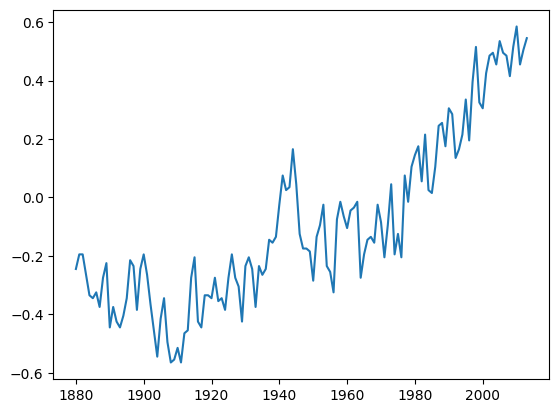

In [30]:
# # Your plotting code here.
# plt.subplot(1,1,(1,1)).plot(year, temperature)
# # plt.subplot())
# plt.subplot(1,1,(2,1)).plot(year, sealevel)
# # plt.subplot(2).plot(year, sealevel_sigma)
# plt.show()

**Part A (ii):** How does the uncertainty in global mean sea levels change as a function of time?  When is the uncertainty the highest?  Give one reason why you think this might be the case.

---

**Part B:**  The "out-of-box" sea-level model

In your plot from **(a)**, you should see quite an apparent relationship between increasing temperatures and rising sea levels.  Seems like someone should try to model the relationship between those two, huh?

In the helper function, slr, below, a simple model for temperature-driven changes in global mean sea level (GMSL) is defined. This is the model of [Rahmstorf (2007)](http://science.sciencemag.org/content/315/5810/368).

The `slr` model takes two parameters, $\alpha$ and $T_{eq}$, and requires a time series of global mean temperatures: `slr(alpha, Teq, temperature)`.
* `alpha` is the sensitivity of sea-level changes to changes in global temperature. The units for $\alpha$ are millimeters of sea-level changes per year, or mm y$^{-1}$.
* `Teq` is the equilibrium global mean temperature, with units of degrees Celsius.
* `temperature` is the time series of global mean surface temperatures, assumed to be relative to the 1961-1990 mean.

For now, you do not need to worry too much about how this model works.  It is very simple, and widely used, but the point here is that you can plug in a particular set of temperatures (the model **forcing**) and parameters ($\alpha$ and $T_{eq}$), and out pops a time series of simulated global mean sea levels.

**Our goal:**  pick good values for $\alpha$ and $T_{eq}$, so that when we run the `slr` model using the observations of temperature (which we plotted above), the model output matches well the observations of global mean sea level (which we also plotted above).

The whole process of figuring out what these good parameter values are is called **model calibration**, and it's awesome.  Model Calibration is the point of this problem. Let's have a look at why we need to do this in the first place, shall we?

The default parameter choices given in the Rahmstorf (2007) paper are $\alpha=3.4$ mm y$^{-1}$ and $T_{eq} = -0.5\ ^{\circ}$C.

**Your task for Part B:**

Make a plot that contains:
* the observed sea level data as scatter points
* the modeled sea levels as a line, using the temperature observations from above as the `temperature` input
* an appropriate legend and axis labels
* $x$ axis is years
* $y$ axis is sea level

Note that after you run the `slr` model, you will need to **normalize** the output relative to the 1961-1990 reference period.  That is because you are going to compare it against data that is also normalized against this reference period. The `years` that correspond to the model output should be the same as the `years` that correspond to the `temperature` input. Normalizing data can mean several things. Follow the steps outlined below to "normalize" the data in the way needed for this problem:
- Compute the mean of the output of the slr model for the years from 1961-1990 (inclusive).
- Subtract this value from each entry in the "sealevel" list (list returned by the slr function)


Make sure that you normalize the data prior to plotting.

In [ ]:
# helpers

def slr(alpha, Teq, temperature):
    '''sea-level emulator of Rahmstorf 2007 (DOI: 10.1126/science.1135456)
    Takes global mean temperature as forcing, and parameters:
    alpha = temperature sensitivity of sea level rise, and
    Teq   = equilibrium temperature,
    and calculates a rise/fall in sea levels, based on whether the temperature
    is warmer/cooler than the equilibrium temperature Teq.
    Here, we are only worrying about alpha (for now!)'''

    n_time = len(temperature)
    deltat = 1
    sealevel = [0]*n_time
    sealevel[0] = -134
    for t in range(n_time-1):
        sealevel[t+1] = sealevel[t] + deltat*alpha*(temperature[t]-Teq)

    return sealevel

In [ ]:
# Your code here.

Your plot above ought to show decent match for the late 1900s, but diverge a bit further back in time.

**The point:**  We can do better than this "out-of-the-box" version of the Rahmstorf sea level model.

**Part C:**   Figuring out our objective function

As our **objective function**, we will use the joint likelihood function of the observed sea level data, given the model simulation.  The following is a detailed description of the derivation of the objective function for a hill climbing routine. **Note, you do not need to do anything for this part other than to read about the objective function and execute the cell below, then move to part D.**

For a single data point in year $i$, $y_i$, with associated uncertainty $\sigma_i$, we can assume the likelihood for our model simulation in year $i$, $\eta_i$, follows a normal distribution centered at the data point.  The model simulation is a **deterministic** result of our parameter choices $\alpha$ and $T_{eq}$, so we write the likelihood as:

$$L(y_i \mid \alpha, T_{eq}) = \dfrac{1}{\sqrt{2 \pi} \sigma_i} e^{-\dfrac{(\eta_i(\alpha, T_{eq}) - y_i)^2}{2\sigma_i^2}}$$

But that only uses a single data point.  Let's use all the data!  The **joint likelihood** is the product of all of the likelihoods associated with the individual data points. But that is the product of a lot of numbers that are less than 1, so it will be **tiny**.  Instead, we should try to optimize the **joint log-likelihood**, which is simply the (natural) logarithm of the joint likelihood function.

If we assume the observational data ($y_i$) are all independent, then the joint log-likelihood is:

$$l(\mathbf{y} \mid \alpha, T_{eq}) = -\dfrac{N}{2} \log{(2\pi)} - \sum_{i=1}^N \log{(\sigma_i)} - \dfrac{1}{2}\sum_{i=1}^N \left( \dfrac{\eta_i(\alpha, T_{eq}) - y_i}{\sigma_i} \right)^2$$

where, $\mathbf{y} = [y_1, y_2, \ldots, y_N]$ is the entire vector (list) of sea level observations, $\eta(\alpha, T_{eq}) = [\eta_1(\alpha, T_{eq}), \eta_2(\alpha, T_{eq}), \ldots, \eta_N(\alpha, T_{eq})]$ is the entire vector (list) of `slr` model output when the parameter values $\alpha$ and $T_{eq}$ are used, and $N$ is the number of observations we have.

**Defining our objective function**

Now define a `log_likelihood(parameters, obs_mu, obs_sigma)` function:
* `parameters`: argument that is a list of two parameter values, $[\alpha, T_{eq}]$
  * within the likelihood function, you will need to generate the model simulation $\eta(\alpha, T_{eq})$ using the input `parameters`, for comparison against the observational data
* `obs_temp`: argument that is a time series (list) of observed global mean temperatures, that will be used to run the `slr` model. Provide a default value of `temperature` for this, because we only have one temperature data set to use, and we don't want to keep 
* `obs_mu`: argument that is a time series (list) of observed values, that will be used for comparison against the `model` output. Provide a default value of `sealevel` here, because we won't be changing the observational data.
* `obs_sigma`: argument that is a time series (list) of the corresponding uncertainties in the observational data. Simiarly, provide a default value of `sealevel_sigma` here, so we can avoid the tedious task of sending the data set into this function.
* all three of these inputs should be lists, and should be the same length
* this routine should return a **single** float number, that is the joint log-likelihood of the given `model` simulation.

In [ ]:
# Here is the objective function. You will be using this function below when you code up hill-climbing and 
# simulated annealing routines.

def log_likelihood(parameters, obs_temp=temperature, obs_mu=sealevel, obs_sigma=sealevel_sigma):
    model = slr(alpha=parameters[0], Teq=parameters[1], temperature=temperature)
    
    # normalize
    reference = (year.index(1961), year.index(1990))
    model -= np.mean(model[reference[0]:(reference[1]+1)])

    return np.sum([np.log(stats.norm.pdf(x=model, loc=obs_mu, scale=obs_sigma))])

**Part D:**  Defining our class structure

Now we will apply a hill-climbing algorithm to tune the $\alpha$ and $T_{eq}$ parameters.

Using our in-class lecture notebook on hill-climbing as a guide, do the following:

* Define a `State` class, with attributes for the parameter values (which define the state) and the objective function value of that state.
* Define a `Problem_hillclimb` **sub-class** of the more general class `Problem`, with:
  * attributes for the current `State` (a `State` object), the `objective_function` (the log-likelihood defined above), and `stepsize`. You will need to play around to decide what an appropriate stepsize is. Keep in mind that you may need a different stepsize for each of $\alpha$ and $T_{eq}$.
  * methods for `moves` (return the list of all possible moves from the current state) and `best_move` (return the move that maximizes the objective function).
  * the `moves` available should be in proper 2-dimensional space.  Do **not** simply optimize one parameter, keeping the other fixed, then optimize the other parameter, while keeping the first fixed.  (*That method *can* work, but there are some theoretical issues that would need to be tackled, and we are not getting into that here.*) You are allowed to restrict yourself to movements along a grid, as long as you entertain steps in both the $\alpha$ and the $T_{eq}$ directions.
* Define the `hill_climb` algorithm, with any necessary modifications (here, and in the above classes) for the new 2-dimensional state space.
  * `hill_climb(problem, n_iter)`:  arguments are a `Problem_hillclimb` object and number of iterations, `n_iter`
  * return a `State` that corresponds to the algorithm's guess at a global maximum

In [ ]:
# Your code here.

Now:
1. define an initial state object, using the default values from Rahmstorf 2007 as a starting point.
2. define a hill-climbing problem object, using this initial state, the log-likelihood objective function, and stepsize(s) of your choosing. (The stepsize(s) may require some playing around to find something you are happy with.)
3. ***hill-climb!!!*** Use a number of iterations that you deem appropriate. 

Play around until you have a simulation that you are happy with.  Then:
1. Print to screen the parameter values and corresponding log-likelihood value.
2. Compare this calibrated log-likelihood value to the "out-of-box" model (above).
3. Make a plot of:
  * the sea level observations as scatter points
  * the uncalibrated model as one line
  * the calibrated model as another line
  * include axis labels and a legend
  
**"Unit tests":**
* As a benchmark, make sure that your log-likelihood is *at least* -500.
* Your calibrated (optimized) model simulation should be going straight through the data points.
* If this isn't the case, remember to normalize your model against the 1961-1990 reference period!

In [ ]:
# Your code here.

**Part E:**  Simulated annealing

Let's re-calibrate the `slr` model. This time, we will use **simulated annealing**. Again, using our in-class activity as a guide, do the following:

* Continue to use your `State` class above.
* Define a `Problem_annealing` sub-class of the `Problem` class, with:
  * attributes for the current `State` (a `State` object), the `objective_function` (the log-likelihood defined above), and `stepsize`. You will need to play around to decide what an appropriate stepsize is. Keep in mind that you may need a different stepsize for each of $\alpha$ and $T_{eq}$.
  * method for `random_move`, to pick a random move **by drawing from a multivariate normal distribution**.  You should use the `stepsize` attribute as the covariance (width) for this.
* Define the `simulated_annealing` algorithm, with any necessary modifications (here, and in the above classes) for the new 2-dimensional state space.
  * `simulated_annealing(problem, n_iter)`:  arguments are a `Problem_annealing` object and number of iterations, `n_iter`
  * return a `State` that corresponds to the algorithm's guess at a global maximum

Subject to the above constraints, you may implement these however you would like.

In [ ]:
# Your code here.

Now:
1. define an initial state object, using the default values from Rahmstorf 2007 as a starting point.
2. define a simulated annealing problem object, using this initial state, the log-likelihood objective function, an appropriate temperature updating schedule and stepsize(s) of your choosing. (The stepsize(s) may require some playing around to find something you are happy with.)
  * note that this "temperature" is distinct from the actual physical temperature used as input to drive the `slr` model
3. ***anneal!!!*** Use a number of iterations that you deem appropriate. 

Play around until you have a simulation that you are happy with.  Then:
1. Print to screen the parameter values and corresponding log-likelihood value.
2. Compare this calibrated log-likelihood value to the "out-of-box" model (above).
3. Make a plot of:
  * the sea level observations as scatter points
  * the uncalibrated model as one line
  * the calibrated model as another line
  * include axis labels and a legend
  
**"Unit tests":**  How does your model look when you plot it against the data? If it doesn't look good, then you failed this unit test :(

In [ ]:
# Your code here.

**Part F:**

Briefly summarize your findings. Specifically discuss the $\alpha$ and $T_{eq}$ parameter values you found in **Part D** and **Part E**. How do these compare to the parameters of the model given by Rahmstorf? Did your hill-climbing and/or your simulated annealing programs find a better fit than the Rahmstorf model? 